### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [3]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [4]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cpu device is available


#### 1. Загрузка данных.

In [9]:
# do not change the code in the block below
# __________start of block__________
import urllib.request
import ssl

# Создаем контекст без проверки SSL (только для тестирования!)
ssl_context = ssl._create_unverified_context()

url = 'https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt'
req = urllib.request.Request(url)

with urllib.request.urlopen(req, context=ssl_context) as response:
    text = response.read().decode('utf-8')
    
text = "".join([x.replace('\t\t', '').lower() for x in text.splitlines(keepends=True)])
# __________end of block__________

#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [10]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [11]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________    

Пример батча:

In [12]:
next(generate_chunk())

array([[83, 45, 70, ..., 45, 62, 76],
       [83,  1, 59, ..., 63, 59, 61],
       [83, 59, 58, ..., 50, 49, 47],
       ...,
       [83, 56, 45, ...,  0,  0, 45],
       [83,  1, 57, ..., 50, 56,  7],
       [83,  0, 47, ..., 62, 63, 50]], shape=(256, 101))

Далее вам предстоит написать код для обучения модели и генерации текста.

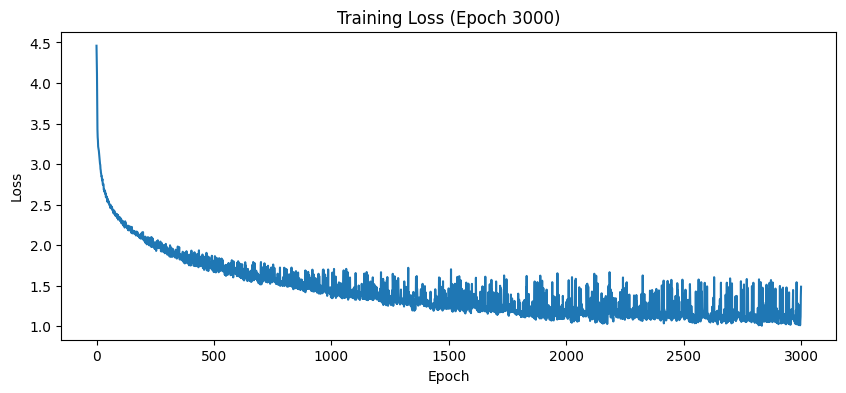

Epoch 3000, Loss: 1.4863


In [13]:
class CharRNN(nn.Module):
    def __init__(self, num_tokens, embedding_dim=64, hidden_size=256):
        super().__init__()
        self.embedding = nn.Embedding(num_tokens, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_tokens)
    
    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

model = CharRNN(num_tokens).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

num_epochs = 3000
losses = []

for epoch in range(num_epochs):
    batch = torch.tensor(next(generate_chunk()), dtype=torch.long).to(device)
    x = batch[:, :-1]
    y = batch[:, 1:]
    
    optimizer.zero_grad()
    output, _ = model(x)
    loss = criterion(output.reshape(-1, num_tokens), y.reshape(-1))
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 500 == 0:
        clear_output(True)
        plt.figure(figsize=(10, 4))
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training Loss (Epoch {epoch+1})')
        plt.show()
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

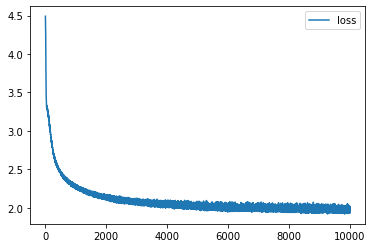

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [14]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else: 
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    
    char_rnn.eval()
    hidden = None
    
    with torch.no_grad():
        output, hidden = char_rnn(x_sequence, hidden)
        
        while x_sequence.shape[1] < max_length + 1:
            logits = output[0, -1] / temperature
            probs = F.softmax(logits, dim=0)
            next_token = torch.multinomial(probs, 1)
            x_sequence = torch.cat([x_sequence, next_token.unsqueeze(0)], dim=1)
            output, hidden = char_rnn(next_token.unsqueeze(0), hidden)
    
    char_rnn.train()
    return ''.join([idx_to_token[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [15]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правил,
еще не простите, велерный пойме
не места ее прочел забы: —
вол барпись ей целик:
ему что в чемудно
люблю, что судьбою красно
прозено лоет без порой простотой,
патьисские тут ничего,
его на смервил догадкой писали
в поседе вышес, о ромный,
из поздравлялся, куда,
и страх уж расказаться ло находит
сосед моеном садимче.
давно ль он предал он ответа,
хоть полубудной,
как меня не воподит:
так, вошел пы редений,
не всирает и гробой.
списина приали, усвокну;
так и следней


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [16]:
seed_phrase = ' мой дядя самых честных правил'

In [17]:
generated_phrases = [
    generate_sample(
        model,
        seed_phrase,
        max_length=500,
        temperature=0.8
    ).replace('<sos>', '')
    for _ in range(10)
]

In [18]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'
    

submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!